<h1> Цель: </h1>
Здесь происходит расчет вероятности для каждого компонента HSV (Hue, Saturation, Value), для состалвение маски облаков.

HSV — это цветовая модель, которая описывает цвет в терминах оттенка (Hue), насыщенности (Saturation) и яркости (Value). Она часто используется в обработке изображений, потому что она более интуитивно понятна для человека, чем традиционная модель RGB (красный, зеленый, синий). Давайте разберем каждую составляющую:

1. Hue (Оттенок)
Hue — это цветовой тон, который описывает «цвет» как таковой. Он измеряется в градусах на круге от 0° до 360°.
- 0° — это красный цвет.
- 120° — это зеленый цвет.
- 240° — это синий цвет.
Модуль Hue позволяет получить представление о том, как изменяется цвет от одного к другому (красный, оранжевый, желтый, зеленый и так далее).
2. Saturation (Насыщенность)
Saturation — это интенсивность или чистота цвета. Чем выше насыщенность, тем более «ярким» и чистым кажется цвет.
- Когда насыщенность равна 0, цвет становится серым (оттенок теряет свою яркость).
- Когда насыщенность равна 100%, цвет максимально яркий и чистый.
3. Value (Яркость)
Value — это яркость или светимость цвета. Чем выше значение, тем ярче цвет.
- Значение 0 означает черный цвет (независимо от оттенка).
- Значение 100 означает максимально яркий цвет, то есть цвет в своей полной насыщенности.

<h2>Статьи</h2>

1. [Статья 1](https://ipabhi.org/repositorio/index.php/rca/article/view/99/109)
2. [Статья 2](https://amt.copernicus.org/articles/10/199/2017/amt-10-199-2017.pdf)
3. [Статья 3](https://www.mdpi.com/2220-9964/7/6/224)
4. [Статья 4](https://arxiv.org/pdf/2212.11369v1)
5. [Статья 5](https://towardsdev.com/how-to-repair-damaged-images-using-inpainting-methods-in-python-using-opencv-339982754137)
v1)


<h2>Набор данных</h2>
Датасеты:

- [38-cloud](https://www.kaggle.com/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images/data)
- [singleImage](https://www.dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/BSETKZ)



In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import savgol_filter

In [5]:
#константы
RES = 256
TRAIN = "38-cloud/train/"
IMG = "img/data/"
MASK = "mask/data/"

In [11]:
def process_img():
    n_samples = len(os.listdir(TRAIN + IMG))  
    H_cloud, S_cloud, V_cloud = np.zeros(256), np.zeros(256), np.zeros(256)
    H_no, S_no, V_no = np.zeros(256), np.zeros(256), np.zeros(256)

    with tqdm(total=n_samples) as bar:
        for img_f, mask_f in zip(os.listdir(TRAIN + IMG), os.listdir(TRAIN + MASK)):
            bar.update(1)

            img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN, IMG, img_f)), cv2.COLOR_BGR2HSV)
            mask = cv2.cvtColor(cv2.imread(os.path.join(TRAIN, MASK, mask_f)), cv2.COLOR_BGR2GRAY)

            for y in range(RES):
                for x in range(RES):
                    if mask[y][x]:  # Cloud pixel
                        H_cloud[img[y][x][0]] += 1
                        S_cloud[img[y][x][1]] += 1
                        V_cloud[img[y][x][2]] += 1
                    else:  # No cloud pixel
                        H_no[img[y][x][0]] += 1
                        S_no[img[y][x][1]] += 1
                        V_no[img[y][x][2]] += 1

    # Compute probabilities and smoothen them
    H = savgol_filter(H_cloud / np.maximum((H_no + H_cloud), np.ones(256)), 11, 4)
    S = savgol_filter(S_cloud / np.maximum((S_no + S_cloud), np.ones(256)), 11, 4)
    V = savgol_filter(V_cloud / np.maximum((V_no + V_cloud), np.ones(256)), 11, 4)

    np.save("H.npy", H, allow_pickle=True)
    np.save("S.npy", S, allow_pickle=True)
    np.save("V.npy", V, allow_pickle=True)
    return H, S, V

In [14]:
H, S, V = process_img()

  1%|▌                                                                             | 148/20023 [00:14<33:06, 10.01it/s]


KeyboardInterrupt: 

In [11]:
H = np.load("H.npy", allow_pickle=True)
S = np.load("S.npy", allow_pickle=True)
V = np.load("V.npy", allow_pickle=True)

In [16]:
def plot(H, S, V):
    X = range(256)
    # Plot smoothened probability graphs for H, S and V
    plt.plot(X, H, color="tab:blue", label="Оттенок", zorder=3)
    plt.plot(X, S, color="tab:red", label="Насыщенность", zorder=3, linestyle=(0, (1, 1)))
    plt.plot(X, V, color="tab:green", label="Яркость", zorder=3, linestyle="dashed")

    plt.ylabel("Вероятность")
    plt.xlabel("Значение компонент")
    plt.title("Вероятность, что облако. По HSV представлению изображений из набора")

    plt.legend()
    plt.xlim(0, 255)
    plt.ylim(0, 1)
    plt.grid(zorder=0)
    plt.show()

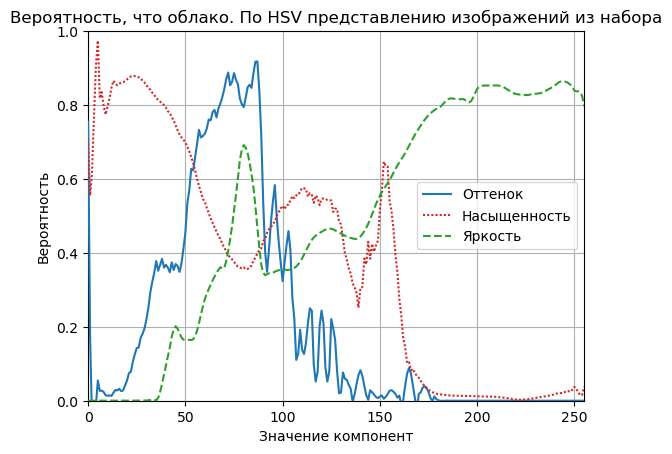

In [17]:
plot(H, S, V)

In [12]:
def predict_cloud_mask(image_path):
    # Чтение изображения, в формате HSV
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2HSV)

    mask_pred = np.zeros(img.shape[:2], dtype=np.uint8)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            h = img[y][x][0]
            s = img[y][x][1]
            v = img[y][x][2] 

            # Вычисление вероятности облака на основе компонент HSV
            P = round((H[h] + S[s] + V[v]) / 3)

            mask_pred[y][x] = 255 if P == 1 else 0

    return mask_pred


def remove_clouds(image, mask):
    mask_dilated = cv2.dilate(mask, None, iterations=5)
    # Заполнение пустоты интерполяцией
    result = cv2.inpaint(image, mask_dilated, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return result

In [13]:
def get_remove_clouds(image_path):
    image = cv2.imread(image_path)
    cloud_mask = predict_cloud_mask(image_path)

    image_without_clouds = remove_clouds(image, cloud_mask)

    # Отображаем исходное изображение, маску и результат
    plt.figure(figsize=(15, 5))

    # Отображаем исходное изображение
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Исходное")
    plt.axis('off')

    # Отображаем маску облаков
    plt.subplot(1, 3, 2)
    plt.imshow(cloud_mask, cmap='gray')
    plt.title("Маска облаков")
    plt.axis('off')

    # Отображаем изображение без облаков
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(image_without_clouds, cv2.COLOR_BGR2RGB))
    plt.title("Обработанное")
    plt.axis('off')

    plt.show()

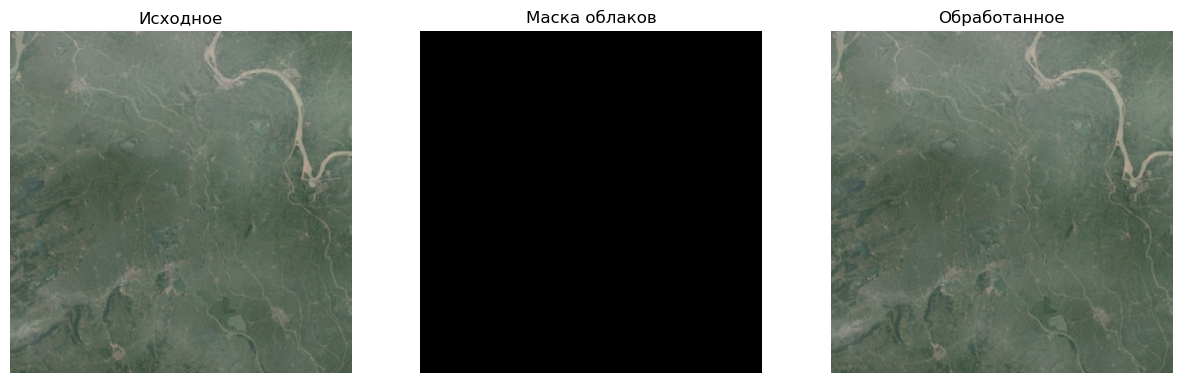

In [14]:
get_remove_clouds("images/488.png")

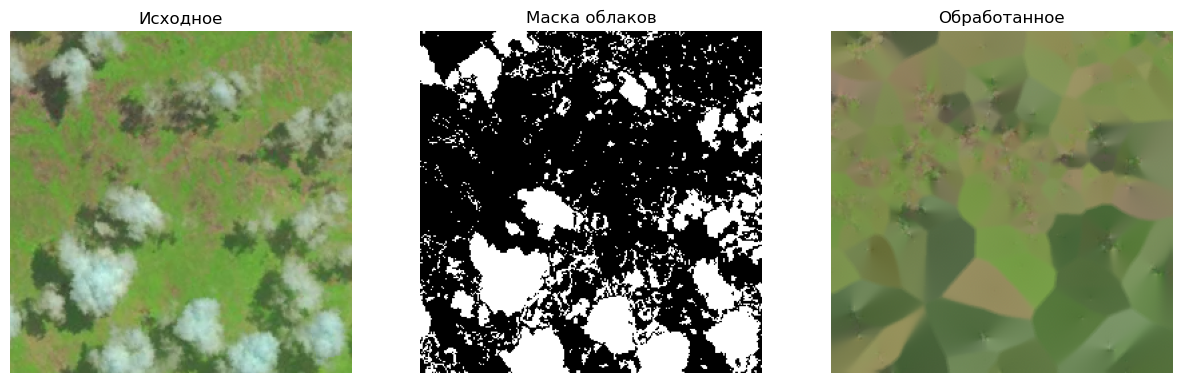

In [33]:
get_remove_clouds("images/30-11-2021_15-55-11-477318.png")

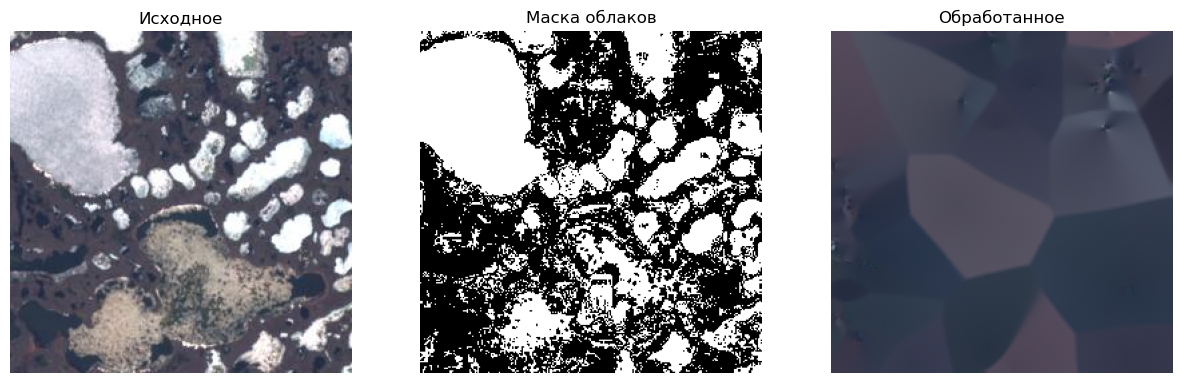

In [38]:
get_remove_clouds("images/03VWG_20000.jpg")

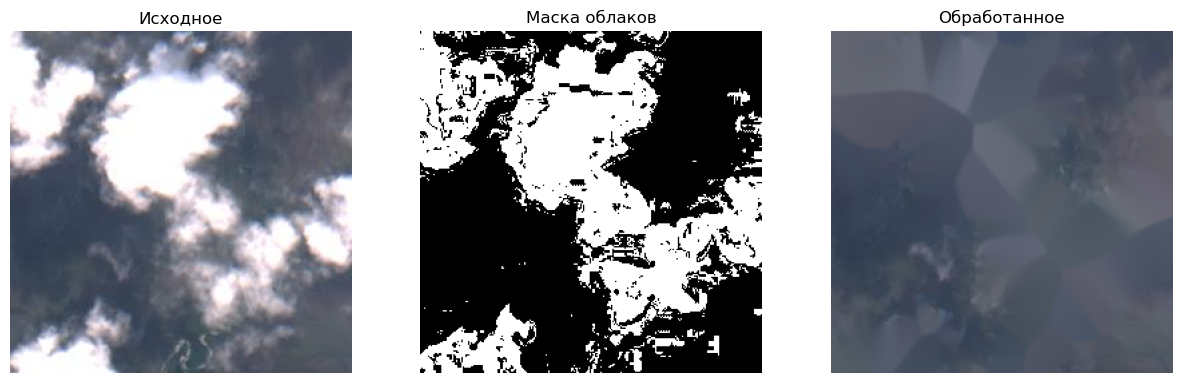

In [41]:
get_remove_clouds("images/07WER_10000.jpg")

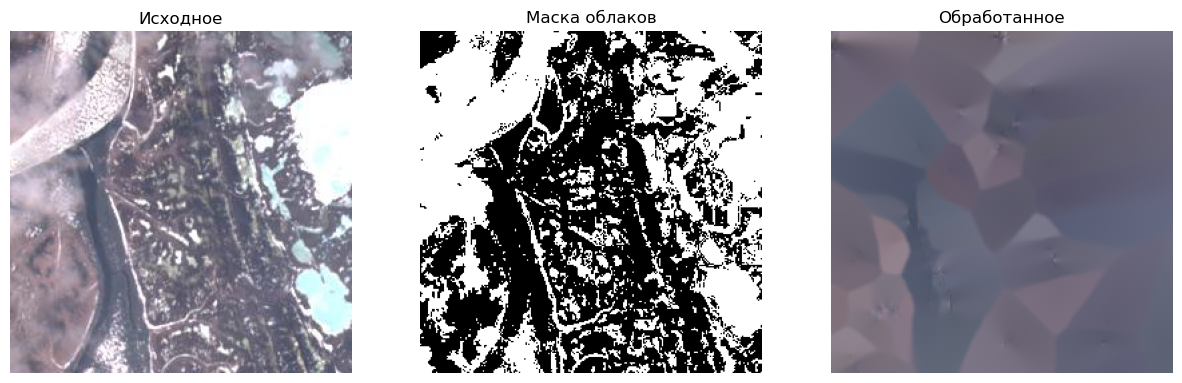

In [42]:
get_remove_clouds("images/03VWG_20001000.jpg")